<a href="https://colab.research.google.com/github/lamsalshrawan/Thesis_RMC_PRnet/blob/main/Hyperparameters_RMC_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#  Import necessary Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from PIL import Image
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler, LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import ClusterCentroids

In [ ]:
# Load the Excel file from Google Drive
file_path = '/content/drive/My Drive/data23march.xlsx'  # Update the path if necessary
data = pd.read_excel(file_path)
print(data.columns)

Index(['Chainage', 'CRS', 'Torque', 'PRchd', 'Thrust', 'PRnet', 'RMR', 'RMC',
       'SE', 'FPI', 'Lithology', 'Formation', 'Weathering', 'Strength'],
      dtype='object')


In [ ]:
# Drop the "Chainage" column
data = data.drop(columns=['Chainage','SE','FPI','Lithology','Formation','Weathering','Strength'])

# Print the remaining columns to verify
print(data.columns)

Index(['CRS', 'Torque', 'PRchd', 'Thrust', 'PRnet', 'RMR', 'RMC'], dtype='object')


In [ ]:
# Define features and target
X = data[['CRS', 'Torque', 'Thrust', 'PRchd', 'PRnet']]  # Replace with actual feature names
y = data['RMC']  # Replace with actual target column name

In [ ]:
# Label Encoding for categorical target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# Robust Scaling for feature set
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance dataset
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"Class distribution after SMOTE: {Counter(y_train_smote)}")

# Define classifiers
classifiers = {
    'SVM': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier()
}


Class distribution after SMOTE: Counter({np.int64(0): 1364, np.int64(1): 1364, np.int64(2): 1364})


In [ ]:
# 🔹 Hyperparameter Grids for GridSearchCV
param_grids = {
    "SVM": {
        'C': [0.1, 1, 10, 40],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    "Decision Tree": {
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 5, 10]
    },
    "KNN": {
        'n_neighbors': list(range(5, 50, 5)),
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'p': [1, 2]
    },
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }
}


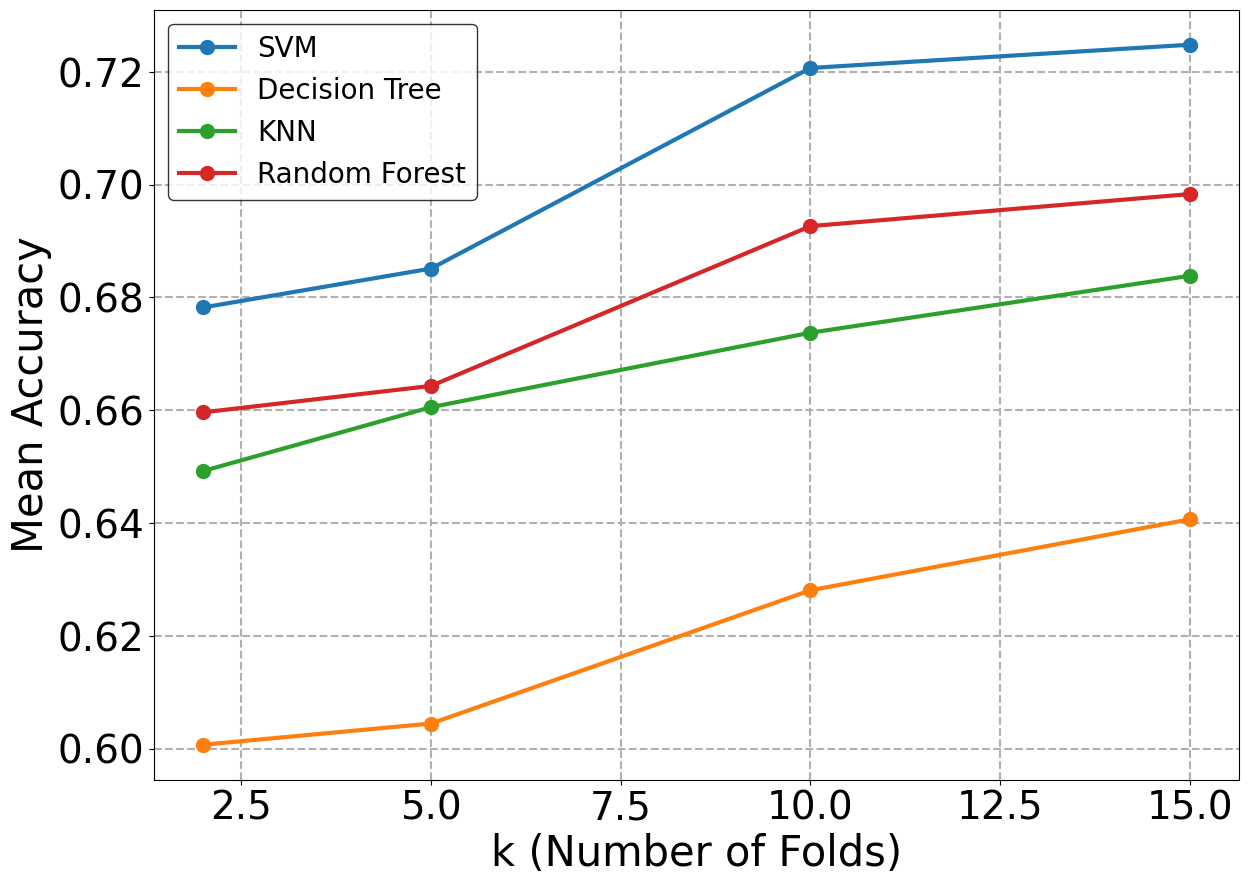

In [ ]:
## CV Performance #Before SMOTE
# **Define k values for cross-validation**
k_values_cv = [2, 5, 10, 15]  # Using integer values for cross-validation

# **Initialize a dictionary to store mean accuracies for each classifier**
mean_accuracies = {name: [] for name in classifiers.keys()}

# **Perform cross-validation for different k values**
for name, model in classifiers.items():
    for k in k_values_cv:
        scores = cross_val_score(model, X_scaled, y_encoded, cv=k, scoring='accuracy')
        mean_accuracies[name].append(np.mean(scores))  # Store computed mean accuracy

# **Define x-ticks for visualization (adding 2.5 for fractional spacing)**
k_values_plot = [2.5, 5, 7.5, 10, 12.5, 15]

# **Create the plot**
plt.figure(figsize=(14, 10), dpi=100)

# **Plot dynamically computed mean accuracies**
for name in classifiers.keys():
    plt.plot(k_values_cv, mean_accuracies[name], marker='o', markersize=10, linewidth=3, label=name)

# **Customize x-ticks, labels, and grid**
plt.xticks(k_values_plot, fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('k (Number of Folds)', fontsize=30)
plt.ylabel('Mean Accuracy', fontsize=30)
plt.grid(True, linestyle='--', linewidth=1.5)

# **Add legend with correct font size and box format**
plt.legend(
    loc="best",
    fontsize=20,
    title="",
    title_fontsize=30,
    frameon=True,  # Box around legend
    edgecolor="black",
    fancybox=True  # Rounded box
)

# **Save and show the plot**
plt.savefig("mean_accuracy_vs_folds.png", dpi=800, bbox_inches='tight')
plt.show()


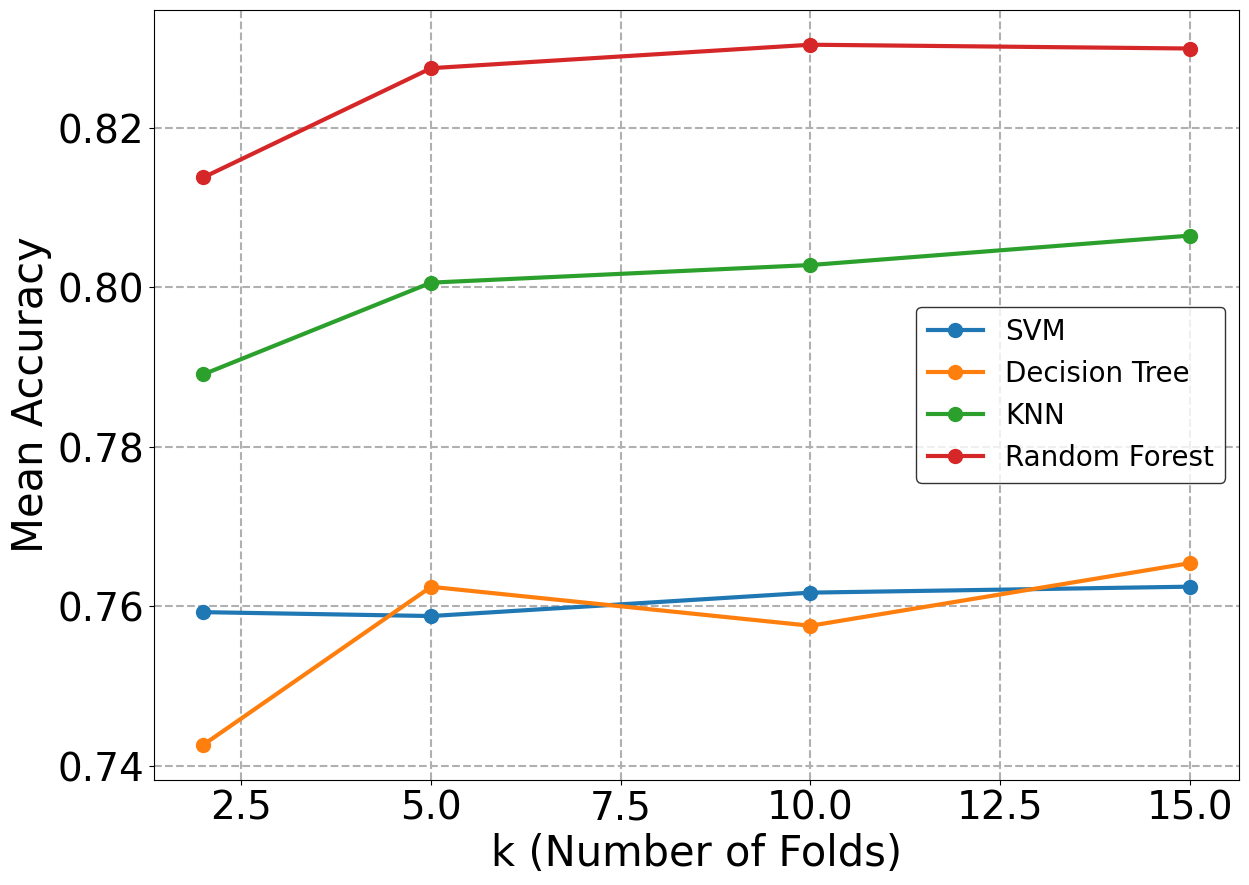

In [ ]:
## CV Performance (After SMOTE)
# **Define k values for cross-validation**
k_values_cv_smote = [2, 5, 10, 15]  # Using integer values for cross-validation

# **Initialize a dictionary to store mean accuracies for each classifier**
mean_accuracies_smote = {name: [] for name in classifiers.keys()}

# **Perform cross-validation for different k values on SMOTE dataset**
for name, model in classifiers.items():
    for k in k_values_cv_smote:
        scores = cross_val_score(model, X_train_smote, y_train_smote, cv=k, scoring='accuracy')
        mean_accuracies_smote[name].append(np.mean(scores))  # Store computed mean accuracy

# **Define x-ticks for visualization (adding 2.5 for fractional spacing)**
k_values_plot_smote = [2.5, 5, 7.5, 10, 12.5, 15]

# **Create the plot**
plt.figure(figsize=(14, 10), dpi=100)

# **Plot dynamically computed mean accuracies after SMOTE**
for name in classifiers.keys():
    plt.plot(k_values_cv_smote, mean_accuracies_smote[name], marker='o', markersize=10, linewidth=3, label=name)

# **Customize x-ticks, labels, and grid**
plt.xticks(k_values_plot_smote, fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('k (Number of Folds)', fontsize=30)
plt.ylabel('Mean Accuracy', fontsize=30)
plt.grid(True, linestyle='--', linewidth=1.5)

# **Add legend with correct font size and box format**
plt.legend(
    loc="best",
    fontsize=20,
    title="",
    title_fontsize=30,
    frameon=True,  # Box around legend
    edgecolor="black",
    fancybox=True  # Rounded box
)

# **Save and show the plot**
plt.savefig("mean_accuracy_vs_folds_smote.png", dpi=800, bbox_inches='tight')
plt.show()


In [ ]:
# **Grid Search with Cross-Validation (Without SMOTE)**
best_models_no_smote = {}
cv_results_no_smote = {}

print("\n🔹 Hyperparameter Tuning WITHOUT SMOTE 🔹")
for model_name, model in classifiers.items():
    grid_search = GridSearchCV(model, param_grids[model_name], cv=10, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)  # Without SMOTE
    best_models_no_smote[model_name] = grid_search.best_estimator_
    cv_results_no_smote[model_name] = grid_search.cv_results_
    print(f"Best parameters for {model_name} (No SMOTE): {grid_search.best_params_}")

# **Grid Search with Cross-Validation (With SMOTE)**
best_models_smote = {}
cv_results_smote = {}

print("\n🔹 Hyperparameter Tuning WITH SMOTE 🔹")
for model_name, model in classifiers.items():
    grid_search = GridSearchCV(model, param_grids[model_name], cv=10, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_smote, y_train_smote)  # With SMOTE
    best_models_smote[model_name] = grid_search.best_estimator_
    cv_results_smote[model_name] = grid_search.cv_results_
    print(f"Best parameters for {model_name} (With SMOTE): {grid_search.best_params_}")




🔹 Hyperparameter Tuning WITHOUT SMOTE 🔹
Best parameters for SVM (No SMOTE): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best parameters for Decision Tree (No SMOTE): {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best parameters for KNN (No SMOTE): {'algorithm': 'auto', 'n_neighbors': 15, 'p': 2, 'weights': 'distance'}
Best parameters for Random Forest (No SMOTE): {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}

🔹 Hyperparameter Tuning WITH SMOTE 🔹
Best parameters for SVM (With SMOTE): {'C': 40, 'gamma': 'auto', 'kernel': 'rbf'}
Best parameters for Decision Tree (With SMOTE): {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best parameters for KNN (With SMOTE): {'algorithm': 'auto', 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
Best parameters for Random Forest (With SMOTE): {'bootstrap': True, 'max_depth': 20, 'max_features':

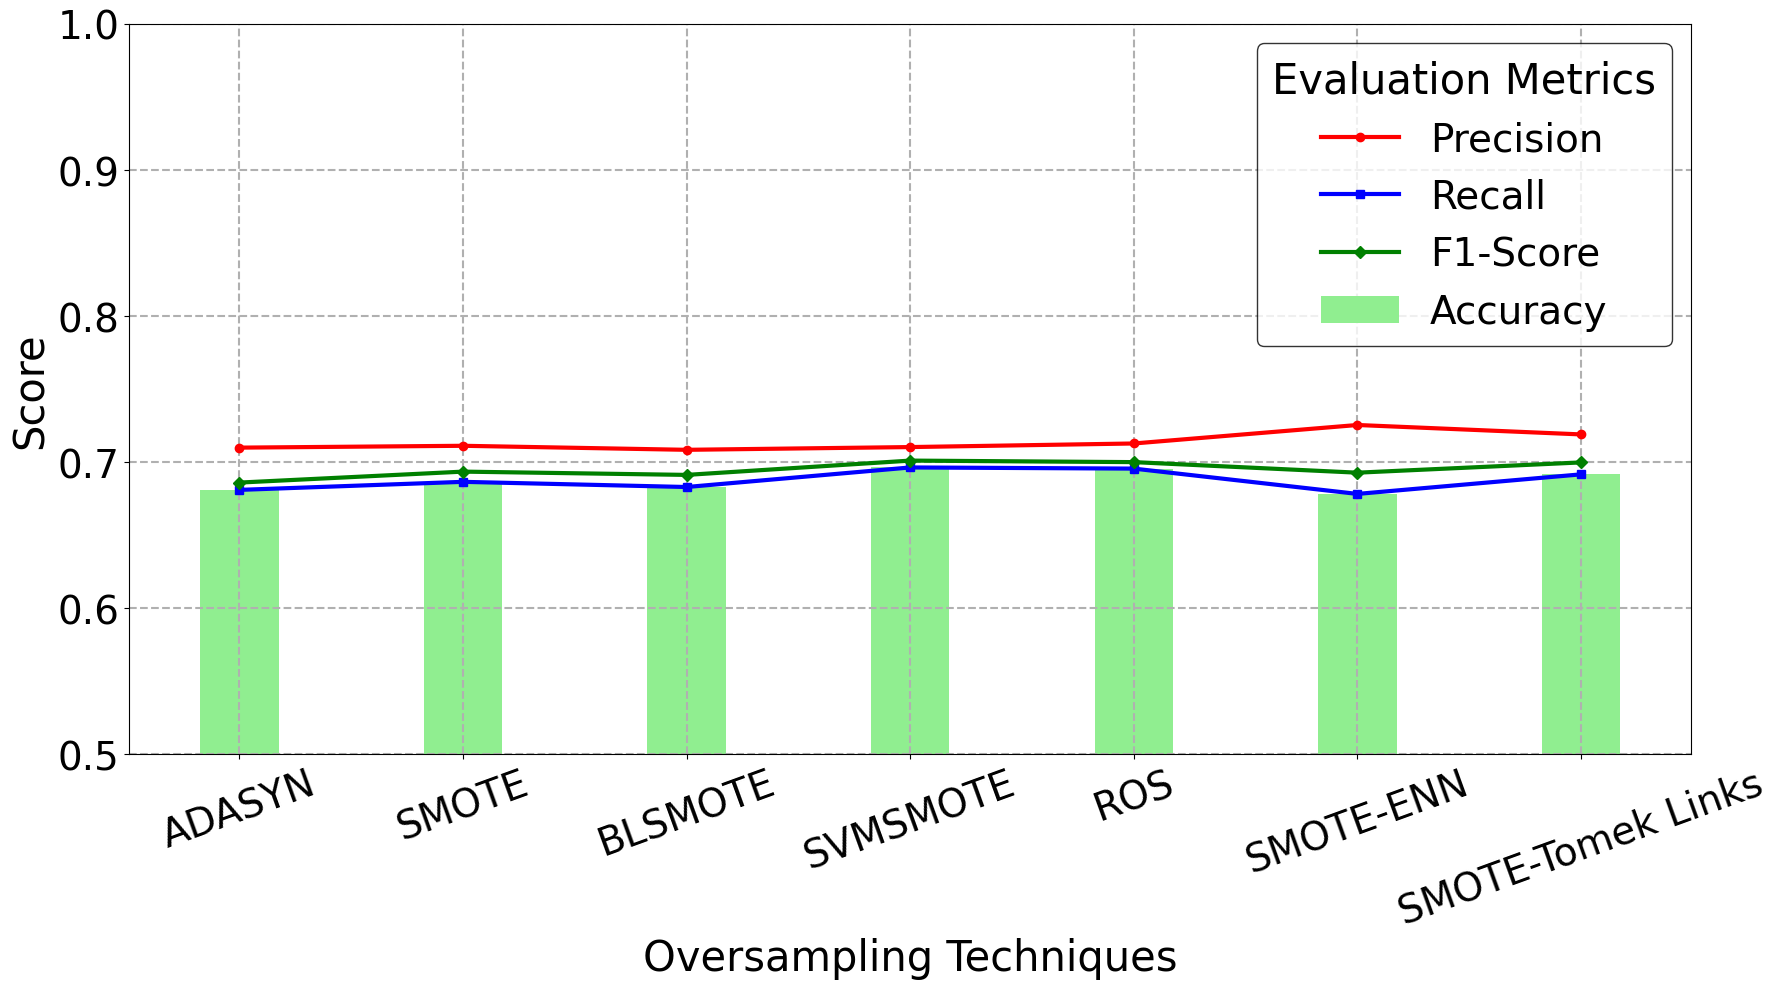

In [ ]:
#FOR OVERSAMPLING TECHNIQUE SELECTION #CORRECT ONE
# Define oversampling methods
oversampling_methods = {
    'ADASYN': ADASYN(sampling_strategy='minority', n_neighbors=5),
    'SMOTE': SMOTE(),
    'BLSMOTE': BorderlineSMOTE(),
    'SVMSMOTE': SVMSMOTE(),
    'ROS': RandomOverSampler(),
    'SMOTE-ENN': SMOTEENN(),
    'SMOTE-Tomek Links': SMOTETomek(),
}

# Initialize storage for oversampling results
oversampling_results = {}

# Model Training & Testing with Oversampling Techniques for all classifiers
for method_name, method in oversampling_methods.items():
    try:
        # Resample data using the oversampling method
        X_resampled, y_resampled = method.fit_resample(X_train, y_train)

        # Initialize storage for this oversampling method's results
        oversampling_results[method_name] = {
            'Accuracy': [],
            'Precision': [],
            'Recall': [],
            'F1-Score': [],
            'ROC AUC': []
        }

        # Train each classifier on the oversampled data
        for model_name, model in classifiers.items():
            model.fit(X_resampled, y_resampled)
            y_pred = model.predict(X_test)

            # Compute evaluation metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            # Compute ROC AUC if the classifier supports it
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)
                roc_auc = roc_auc_score(label_binarize(y_test, classes=np.unique(y_test)), y_proba, average='weighted', multi_class='ovo')
            else:
                roc_auc = np.nan  # Some classifiers may not support this

            # Append the results for this classifier under the current oversampling method
            oversampling_results[method_name]['Accuracy'].append(accuracy)
            oversampling_results[method_name]['Precision'].append(precision)
            oversampling_results[method_name]['Recall'].append(recall)
            oversampling_results[method_name]['F1-Score'].append(f1)
            oversampling_results[method_name]['ROC AUC'].append(roc_auc)

    except ValueError as e:
        print(f"Error in {method_name}: {e}")

# Convert results to DataFrame
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
df_results = pd.DataFrame(index=oversampling_methods.keys(), columns=metrics)

for method in oversampling_methods.keys():
    for metric in metrics:
        df_results.loc[method, metric] = np.mean(oversampling_results[method][metric])

# **Plot evaluation metrics**
plt.figure(figsize=(18, 10), dpi=800)

bar_width = 0.45  # Width for the bars
index = np.arange(len(oversampling_methods.keys()))  # The positions for each bar

# Compute average metrics for each oversampling method
acc_values = [np.mean(oversampling_results[method]['Accuracy']) for method in oversampling_methods.keys()]
precision_values = [np.mean(oversampling_results[method]['Precision']) for method in oversampling_methods.keys()]
recall_values = [np.mean(oversampling_results[method]['Recall']) for method in oversampling_methods.keys()]
f1_values = [np.mean(oversampling_results[method]['F1-Score']) for method in oversampling_methods.keys()]

# Define colors and markers
colors = ['red', 'blue', 'green', 'orange']
markers = ['o', 's', 'D', '^']

# Plot bars for Accuracy (one bar per oversampling technique)
plt.bar(index, acc_values, width=bar_width, color='lightgreen', label='Accuracy')

# Plot lines for the other metrics
plt.plot(index, precision_values, marker=markers[0], color=colors[0], label='Precision', linestyle='-', linewidth=3)
plt.plot(index, recall_values, marker=markers[1], color=colors[1], label='Recall', linestyle='-', linewidth=3)
plt.plot(index, f1_values, marker=markers[2], color=colors[2], label='F1-Score', linestyle='-', linewidth=3)

# **Customize labels and formatting**
plt.xlabel('Oversampling Techniques', fontsize=30)
plt.ylabel('Score', fontsize=30)
plt.xticks(index, oversampling_methods.keys(), rotation=20, fontsize=28)
plt.yticks(fontsize=28)
plt.grid(True, linestyle='--', linewidth=1.5)

# **Legend Formatting (Boxed)**
plt.legend(
    loc="best",
    fontsize=28,
    title="Evaluation Metrics",
    title_fontsize=30,
    frameon=True,  # Box around legend
    edgecolor="black",
    fancybox=True  # Rounded box
)

# **Save and show the plot**
plt.ylim(0, 1)  # Start y-axis from 0.5
plt.tight_layout()
plt.savefig("oversampling_methods_evaluation.png", dpi=1200, bbox_inches='tight')
plt.show()


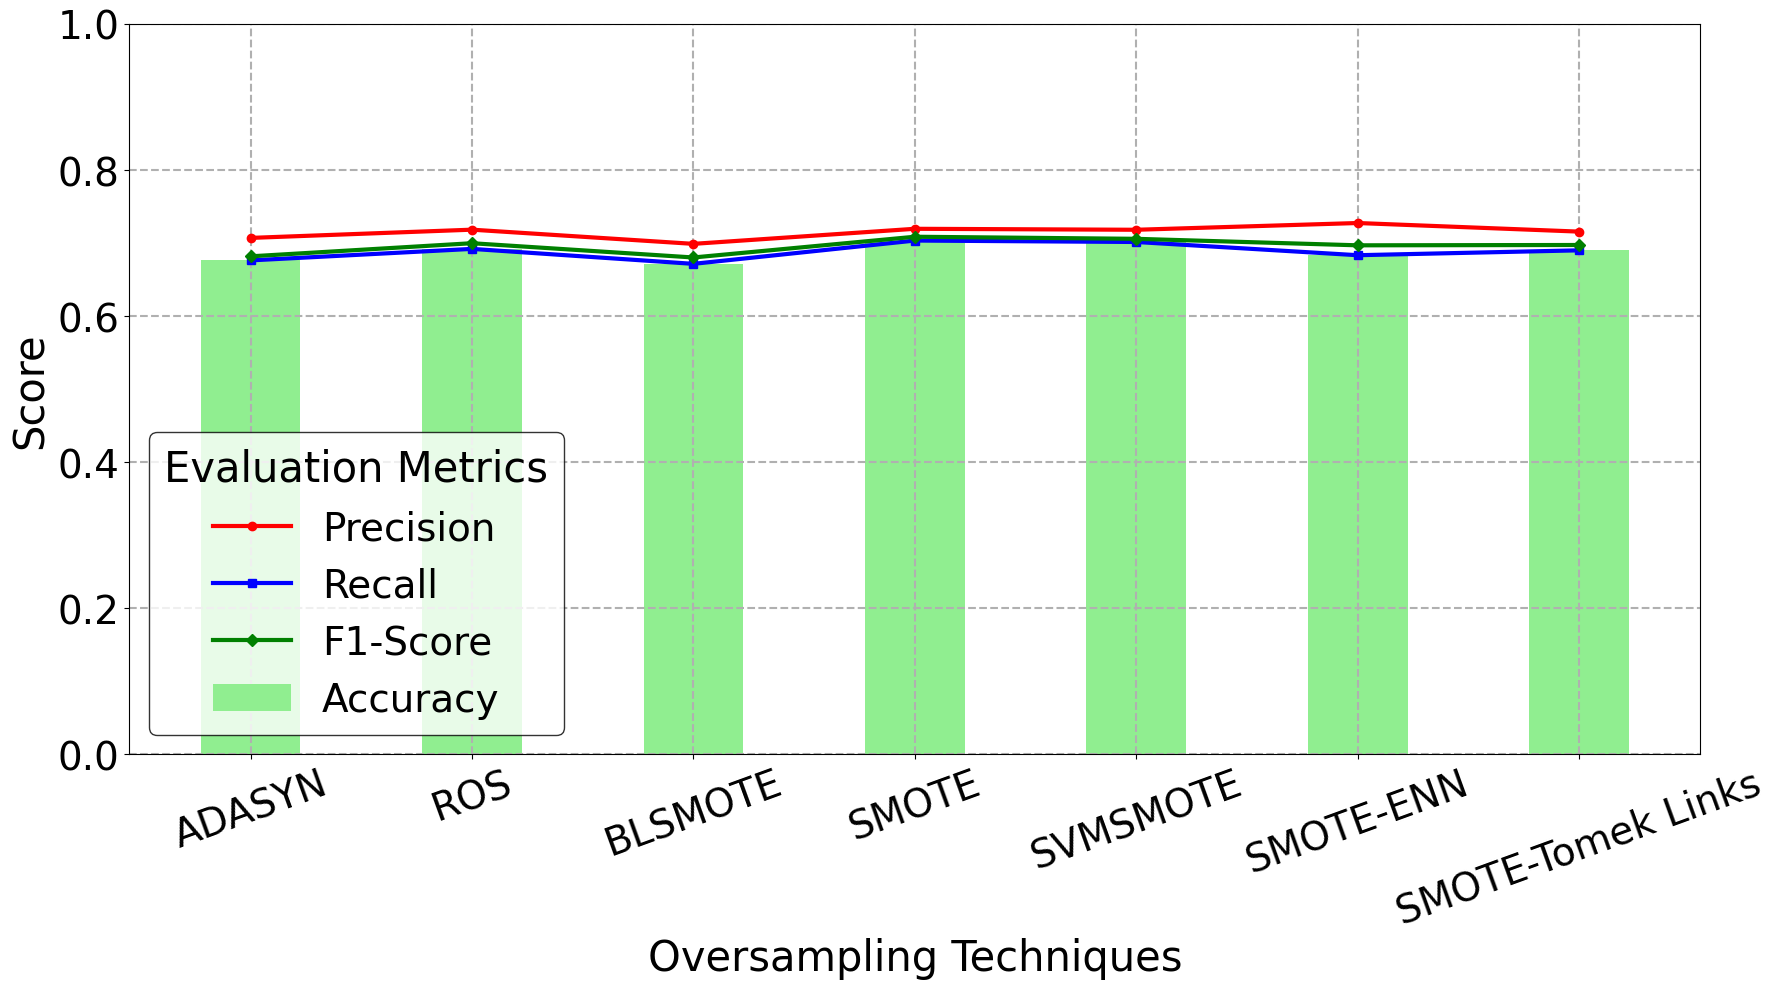

In [ ]:
# FOR OVERSAMPLING TECHNIQUE SELECTION
# Define oversampling methods
oversampling_methods = {
    'ADASYN': ADASYN(sampling_strategy='minority', n_neighbors=5),
    'SMOTE': SMOTE(),
    'BLSMOTE': BorderlineSMOTE(),
    'SVMSMOTE': SVMSMOTE(),
    'ROS': RandomOverSampler(),
    'SMOTE-ENN': SMOTEENN(),
    'SMOTE-Tomek Links': SMOTETomek(),
}

# Initialize storage for oversampling results
oversampling_results = {}

# Model Training & Testing with Oversampling Techniques for all classifiers
for method_name, method in oversampling_methods.items():
    try:
        # Resample data using the oversampling method
        X_resampled, y_resampled = method.fit_resample(X_train, y_train)

        # Initialize storage for this oversampling method's results
        oversampling_results[method_name] = {
            'Accuracy': [],
            'Precision': [],
            'Recall': [],
            'F1-Score': [],
            'ROC AUC': []
        }

        # Train each classifier on the oversampled data
        for model_name, model in classifiers.items():
            model.fit(X_resampled, y_resampled)
            y_pred = model.predict(X_test)

            # Compute evaluation metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            # Compute ROC AUC if the classifier supports it
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)
                roc_auc = roc_auc_score(label_binarize(y_test, classes=np.unique(y_test)), y_proba, average='weighted', multi_class='ovo')
            else:
                roc_auc = np.nan  # Some classifiers may not support this

            # Append the results for this classifier under the current oversampling method
            oversampling_results[method_name]['Accuracy'].append(accuracy)
            oversampling_results[method_name]['Precision'].append(precision)
            oversampling_results[method_name]['Recall'].append(recall)
            oversampling_results[method_name]['F1-Score'].append(f1)
            oversampling_results[method_name]['ROC AUC'].append(roc_auc)

    except ValueError as e:
        print(f"Error in {method_name}: {e}")

# Convert results to DataFrame
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
df_results = pd.DataFrame(index=oversampling_methods.keys(), columns=metrics)

for method in oversampling_methods.keys():
    for metric in metrics:
        df_results.loc[method, metric] = np.mean(oversampling_results[method][metric])

# **Plot evaluation metrics**
plt.figure(figsize=(18, 10), dpi=100)

bar_width = 0.45  # Width for the bars
index = np.arange(len(oversampling_methods.keys()))  # The positions for each bar

# Compute average metrics for each oversampling method
acc_values = [np.mean(oversampling_results[method]['Accuracy']) for method in oversampling_methods.keys()]
precision_values = [np.mean(oversampling_results[method]['Precision']) for method in oversampling_methods.keys()]
recall_values = [np.mean(oversampling_results[method]['Recall']) for method in oversampling_methods.keys()]
f1_values = [np.mean(oversampling_results[method]['F1-Score']) for method in oversampling_methods.keys()]

# Define colors and markers
colors = ['red', 'blue', 'green', 'orange']
markers = ['o', 's', 'D', '^']

# Plot bars for Accuracy (one bar per oversampling technique)
plt.bar(index, acc_values, width=bar_width, color='lightgreen', label='Accuracy')

# Plot lines for the other metrics
plt.plot(index, precision_values, marker=markers[0], color=colors[0], label='Precision', linestyle='-', linewidth=3)
plt.plot(index, recall_values, marker=markers[1], color=colors[1], label='Recall', linestyle='-', linewidth=3)
plt.plot(index, f1_values, marker=markers[2], color=colors[2], label='F1-Score', linestyle='-', linewidth=3)

# **Customize labels and formatting**
custom_labels = ['ADASYN', 'ROS', 'BLSMOTE', 'SMOTE', 'SVMSMOTE', 'SMOTE-ENN', 'SMOTE-Tomek Links']
plt.xlabel('Oversampling Techniques', fontsize=30)
plt.ylabel('Score', fontsize=30)
plt.xticks(index, custom_labels, rotation=20, fontsize=28)
plt.yticks(fontsize=28)
plt.grid(True, linestyle='--', linewidth=1.5)

# **Legend Formatting (Boxed)**
plt.legend(
    loc="best",
    fontsize=28,
    title="Evaluation Metrics",
    title_fontsize=30,
    frameon=True,  # Box around legend
    edgecolor="black",
    fancybox=True  # Rounded box
)

# **Save and show the plot**
plt.ylim(0, 1)  # Start y-axis from 0.5
plt.tight_layout()
plt.savefig("oversampling_methods_evaluation.png", dpi=1200, bbox_inches='tight')
plt.show()


In [ ]:
# Import required libraries for saving and downloading
import pandas as pd
from google.colab import files  # For downloading files in Colab

# Display the DataFrame to verify the results
print("📌 Evaluation Metrics for Oversampling Techniques (Averaged Across Classifiers)")
display(df_results)

# Save the DataFrame to an Excel file
excel_file_path = 'oversampling_methods_metrics.xlsx'
df_results.to_excel(excel_file_path, index=True)  # Keep index (oversampling methods) in the Excel file

print(f"Results saved to {excel_file_path}")

# Download the Excel file (for Google Colab)
files.download(excel_file_path)

📌 Evaluation Metrics for Oversampling Techniques (Averaged Across Classifiers)


,Accuracy,Precision,Recall,F1-Score,ROC AUC
ADASYN,0.676378,0.707158,0.676378,0.681935,0.77996
SMOTE,0.692126,0.718437,0.692126,0.699897,0.785273
BLSMOTE,0.671654,0.699016,0.671654,0.680368,0.769209
SVMSMOTE,0.703543,0.719642,0.703543,0.708763,0.783445
ROS,0.701575,0.718308,0.701575,0.705918,0.78839
SMOTE-ENN,0.683465,0.727544,0.683465,0.697015,0.784754
SMOTE-Tomek Links,0.690157,0.715769,0.690157,0.697466,0.783847


Results saved to oversampling_methods_metrics.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>